In [42]:
import os
import numpy as np
import pandas as pd
import itertools as it
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.calibration import calibration_curve ,CalibrationDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, brier_score_loss, classification_report, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, log_loss


In [43]:
 
#X_train_aug = pd.read_csv("data/dataset/augmented/xtrain_sig0005_sca07_10.csv")

X_train = pd.read_csv("data/dataset/xtrain.csv")
y_train = pd.read_csv("data/dataset/ytrain.csv")

X_test = pd.read_csv("data/dataset/xtest.csv")
y_test = pd.read_csv("data/dataset/ytest.csv")

raw = pd.read_csv("data/dataset/raw.csv")

wavelengths = raw.iloc[100:2000,0].to_numpy(dtype=float)
 

# Clip the extreme wavelengths
X_train = X_train.iloc[:,100:2000]
X_test = X_test.iloc[:,100:2000]
y_train = y_train.iloc[:, 1]
y_test = y_test.iloc[:, 1]

#Convert to Array
X_test = X_test.to_numpy()
X_train = X_train.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()

#Encode labels
le = LabelEncoder()
y_enc = le.fit_transform( y_train  )
y_enc_test = le.fit_transform( y_test  )

Preprocessing Stage
---
- Savgol Filter
- PCA

In [44]:
# Apply a savgol filter to both train and test data
X_train = savgol_filter(X_train, window_length=50, polyorder=1,deriv=1,axis=1)
X_test = savgol_filter(X_test, window_length=50, polyorder=1,deriv=1,axis=1)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply the PCA, for a variance of 99%
pca = PCA(
  n_components=0.99,
  svd_solver='full'
)
X_pca = pca.fit_transform( X_scaled ) 

# Transformation reports
print("Original shape:", X_scaled.shape)
print("PCA shape:", X_pca.shape)

Original shape: (839, 1900)
PCA shape: (839, 26)


SVM setup
---

- > SVM defined with parameters
- > SVM integrated into pipeline, together with PCA

In [45]:

svm = SVC(
    C = 2,
    kernel = "linear",
    decision_function_shape = "ovo",
    class_weight = "balanced",
    probability = True
)

pipeline = Pipeline([
    ("scaler", scaler),
    ("pca", pca),
    ("svm", svm)
])

Work Flow Setup
---

- > K - folds setup

In [46]:
K = 4  # Number of folds
skf = StratifiedKFold(
  n_splits=K, 
  shuffle=True, 
  random_state=42
)

# Perform cross-validation
scores = cross_val_score(
  pipeline, 
  X_train, 
  y_train, 
  cv=skf, 
  scoring='accuracy'
)

print(f"Cross-validation accuracy for each fold: {scores}")
print(f"Mean accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation accuracy for each fold: [0.85238095 0.84761905 0.84285714 0.79904306]
Mean accuracy: 0.8355 ± 0.0213


In [47]:
class SVM:
  def __init__(
      self, 
      C = 3, 
      n_folds=5, 
      n_components=None, 
      kernel = "linear",
      decision_function_shape = "ovo",
      class_weights = "balanced", 
      random_state=0 
    ):
    self.C = C
    self.K = n_folds
    self.n_components = n_components
    self.kernel = kernel
    self.decision_function_shape = decision_function_shape
    self.class_weights = class_weights
    self.random_state = random_state

    self.pipeline = None
    self.scores_ = None
    self.results = [ ]

  def build_pipeline(self):
    steps = [ ]
    steps.append(
      ('scaler', StandardScaler( ) )
    ) 
    if self.n_components is not None:
      steps.append(
        ('pca', 
          PCA(
            n_components=self.n_components, 
            svd_solver='full'
          )
        )
      )

    steps.append(
      ('SVM', 
        SVC( 
            C = 2,
            kernel = "linear",
            decision_function_shape = "ovo",
            class_weight = "balanced",
            probability = True
        )
      )
    )
    self.pipeline = Pipeline(steps)

  def fit(self, X, y, full=False):
    self.build_pipeline( )
    skf = StratifiedKFold(
      n_splits=self.K, 
      shuffle=True, 
      random_state=self.random_state
    )

    self.scores_ = cross_val_score(
      self.pipeline, 
      X, 
      y, 
      cv=skf, 
      scoring='accuracy'
    )

    if( full ):  
      self.pipeline.fit(X, y)

    return self

  def search(self, X, y, C_list, kernel_list, decision_function_shape_list, class_weight_list, pca_list):
    total_configs = (
      len(C_list)
      * len(kernel_list)
      * len(decision_function_shape_list)
      * len(class_weight_list)
      * len(pca_list)
    )

    with tqdm(total=total_configs, desc="SVM hyperparameter search") as pbar:
      for C, kernel, dfs, cw, n_comp in it.product(
        C_list, kernel_list, decision_function_shape_list, class_weight_list, pca_list
      ):
        self.C = C
        self.kernel = kernel
        self.dfs = dfs
        self.class_weights = cw
        self.n_components = n_comp

        self.fit(X, y)

        self.results.append({
          "C": C,
          "kernel": kernel,
          "decision_function_shape": dfs,
          "class_wheights": cw,
          "pca": n_comp,
          "mean_accuracy": self.scores_.mean(),
          "std_accuracy": self.scores_.std()
        })

        pbar.update(1)

    return self.results

  def predict(self, X):
    if self.pipeline is None:
      raise RuntimeError("Model has not been fitted yet.")
    return self.pipeline.predict(X)

  def predict_proba(self, X):
    if self.pipeline is None:
      raise RuntimeError("Model has not been fitted yet.")
    return self.pipeline.predict_proba(X)

  def summary(self):
    if self.scores_ is None:
      print("Fit the model first.")
      return

    print(f"Fitting={self.C} with kernel={self.kernel}({self.dfs}) and weights={self.class_weights} and PCA={self.n_components}" )
    print(f"Cross-validation accuracy per fold: {self.scores_}")
    print(f"Mean accuracy: {self.scores_.mean():.4f} ± {self.scores_.std():.4f}")

Test Setup 
----

In [48]:
model = SVM( n_folds=8 )

results = model.search(
  X_train, y_train,
  C_list=[0.1, 0.5, 1, 1.5, 2 ,2.5],
  kernel_list=["linear"],
  decision_function_shape_list=["ovo"], 

  class_weight_list=[ {"balanced"},
                     {"PET": 0.650 , "PP":0.95, "PE": 1.03, "PS": 1.1}, 
                     {"PET": 0.650 , "PP":0.90, "PE": 1.10, "PS": 1.3},
                     {"PET": 0.500 , "PP":0.80, "PE": 1.20, "PS": 1.0}],
  pca_list=[None, 0.95, 0.99, 0.999]
)

SVM hyperparameter search:   0%|          | 0/96 [00:00<?, ?it/s]

Save SVM Results 
---

In [49]:
dataset_dir_path = "c:/Users/filip/APC/project/plastic-material-classification-hyperspectral-data/HyperParamResults"
os.makedirs(dataset_dir_path, exist_ok=True)

scores_path = os.path.join(dataset_dir_path, "svm_results.csv")
 
scores_path = os.path.join( dataset_dir_path, "svm_results.csv" )

df_results = pd.DataFrame( results )
df_results.sort_values( "mean_accuracy", ascending=False ).head( )
df_results.to_csv( scores_path, index=False )

print(f"Scores saved at {scores_path}")

Scores saved at c:/Users/filip/APC/project/plastic-material-classification-hyperspectral-data/HyperParamResults\svm_results.csv


In [50]:
print(pd.DataFrame(results))

      C  kernel decision_function_shape  \
0   0.1  linear                     ovo   
1   0.1  linear                     ovo   
2   0.1  linear                     ovo   
3   0.1  linear                     ovo   
4   0.1  linear                     ovo   
..  ...     ...                     ...   
91  2.5  linear                     ovo   
92  2.5  linear                     ovo   
93  2.5  linear                     ovo   
94  2.5  linear                     ovo   
95  2.5  linear                     ovo   

                                      class_wheights    pca  mean_accuracy  \
0                                         {balanced}    NaN       0.927301   
1                                         {balanced}  0.950       0.787821   
2                                         {balanced}  0.990       0.848615   
3                                         {balanced}  0.999       0.911813   
4   {'PET': 0.65, 'PP': 0.95, 'PE': 1.03, 'PS': 1.1}    NaN       0.927301   
..             

Load Top Model
---

In [51]:
best_mean = pd.DataFrame([ max( results, key=lambda r: r["mean_accuracy"] ) ])
best_std  = pd.DataFrame([ min( results, key=lambda r: r["std_accuracy"] ) ])

best_mean_row = best_mean.iloc[0]
model_bm = SVM( 
  C=int(best_mean_row['C']),
  n_folds=20,
  n_components=None if pd.isna(best_mean_row['pca']) else float(best_mean_row['pca']),
  kernel=best_mean_row["kernel"],
  decision_function_shape=best_mean_row["decision_function_shape"],
  class_weights=best_mean_row["class_wheights"],
  random_state=0
)

best_std_row = best_std.iloc[0]
model_bs = SVM( 
  C=int(best_std_row['C']),
  n_folds=20,
  n_components=None if pd.isna(best_std_row['pca']) else float(best_std_row['pca']),
  kernel=best_std_row['kernel'],
  decision_function_shape=best_std_row["decision_function_shape"],
  class_weights=best_std_row['class_wheights'],
  random_state=0
)

model_bm.fit(X_train, y_train, True )
model_bs.fit(X_train, y_train, True )

print( best_mean )
print( best_std )
print(classification_report(y_test, model_bm.predict(X_test)))
print(classification_report(y_test, model_bs.predict(X_test)))

     C  kernel decision_function_shape class_wheights   pca  mean_accuracy  \
0  0.1  linear                     ovo     {balanced}  None       0.927301   

   std_accuracy  
0      0.030453  
     C  kernel decision_function_shape class_wheights   pca  mean_accuracy  \
0  0.1  linear                     ovo     {balanced}  0.99       0.848615   

   std_accuracy  
0      0.022654  
              precision    recall  f1-score   support

          PE       0.98      0.96      0.97        46
         PET       0.99      0.96      0.97        75
          PP       0.98      0.98      0.98        53
          PS       0.92      1.00      0.96        36

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210

              precision    recall  f1-score   support

          PE       0.75      0.85      0.80        46
         PET       0.97      0.79      0.87        75
          PP    

Feed Results to Metrics class
---

In [52]:
class kNN_Metric:
  def __init__(
    self,
    model, 
    X_test, 
    y_test
  ):
    self.model = model
    self.X_test = X_test
    self.y_test = y_test

    self.y_pred = None
    self.y_proba = None

  def predict( self ):
    self.y_pred = self.model.predict(self.X_test)
    self.y_proba = self.model.predict_proba(self.X_test)

  def classification_metrics(self):
    self.y_pred = le.fit_transform(self.y_pred)
    return {
      "accuracy": accuracy_score( self.y_test, self.y_pred ),
      "balanced_accuracy": balanced_accuracy_score( self.y_test, self.y_pred )
    }

  def classwise_metrics(self):
    precision, recall, f1, support = precision_recall_fscore_support(
      self.y_test,
      self.y_pred,
      average=None
    )

    return {
      "precision": precision,
      "recall": recall,
      "f1": f1,
      "support": support,
      "confusion_matrix": confusion_matrix( self.y_test, self.y_pred ),
      "classification_report": classification_report( self.y_test, self.y_pred )
    }

  def probabilistic_metrics(self):
    return {
      "log_loss": log_loss(self.y_test, self.y_proba),
      "brier_score": self._multiclass_brier_score( self.y_test, self.y_proba  )
    }

  def _multiclass_brier_score(self, y_true, y_proba):
    n_classes = y_proba.shape[1]
    y_true_oh = np.eye(n_classes)[y_true]
    return np.mean(
      np.sum( 
        (y_proba - y_true_oh) ** 2, 
        axis=1
      )
    )

  def expected_calibration_error(self, n_bins=10):
    confidences = np.max(self.y_proba, axis=1)
    predictions = np.argmax(self.y_proba, axis=1)
    correct = (predictions == self.y_test).astype(int)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
      mask = (confidences > bins[i]) & (confidences <= bins[i + 1])
      if np.any(mask):
        acc = correct[mask].mean()
        conf = confidences[mask].mean()
        ece += np.abs(acc - conf) * np.sum(mask) / len(confidences)

    return ece

  def plot_reliability_diagram(self, n_bins=10):
    confidences = np.max(self.y_proba, axis=1)
    predictions = np.argmax(self.y_proba, axis=1)
    correct = (predictions == self.y_test).astype(int)

    frac_pos, mean_conf = calibration_curve(
      correct, confidences, n_bins=n_bins
    )

    plt.figure(figsize=(5, 5))
    plt.plot(mean_conf, frac_pos, "o-", label="SVM")
    plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect calibration")
    plt.xlabel("Mean confidence")
    plt.ylabel("Empirical accuracy")
    plt.title("Reliability Diagram")
    plt.grid(True)
    plt.legend()
    plt.show()

  def plot_confusion_matrix(self, normalize=True, cmap="Blues"):
    cm = self.classwise_metrics( )["confusion_matrix"]

    if normalize:
      cm = cm / cm.sum(axis=1, keepdims=True)
      title = "Normalized Confusion Matrix"
    else:
      title = "Confusion Matrix (Counts)"

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar(im, ax=ax)

    n_classes = cm.shape[0]
    ticks = np.arange(n_classes)

    ax.set(
      xticks=ticks,
      yticks=ticks,
      xlabel="Predicted label",
      ylabel="True label",
      title=title
    )

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0

    for i in range(n_classes):
      for j in range(n_classes):
        ax.text(
          j, i, format(cm[i, j], fmt),
          ha="center", va="center",
          color="white" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.show()

  def evaluate(self):
    self.predict( )

    results = {
      "classification": self.classification_metrics(),
      "classwise": self.classwise_metrics(),
      "probabilistic": self.probabilistic_metrics(),
      "ece": self.expected_calibration_error(),
    }

    return results

==== Max mean model
Classification:    accuracy  balanced_accuracy
0  0.971429           0.974413
Probabilistic:    log_loss  brier_score
0  0.467009     0.247525
ECE: 0.2680373109848219
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.99      0.96      0.97        75
           2       0.98      0.98      0.98        53
           3       0.92      1.00      0.96        36

    accuracy                           0.97       210
   macro avg       0.97      0.97      0.97       210
weighted avg       0.97      0.97      0.97       210



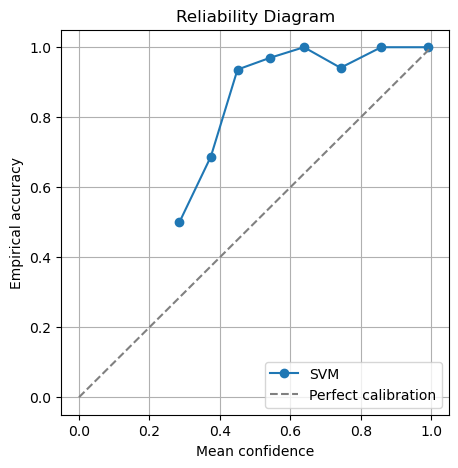

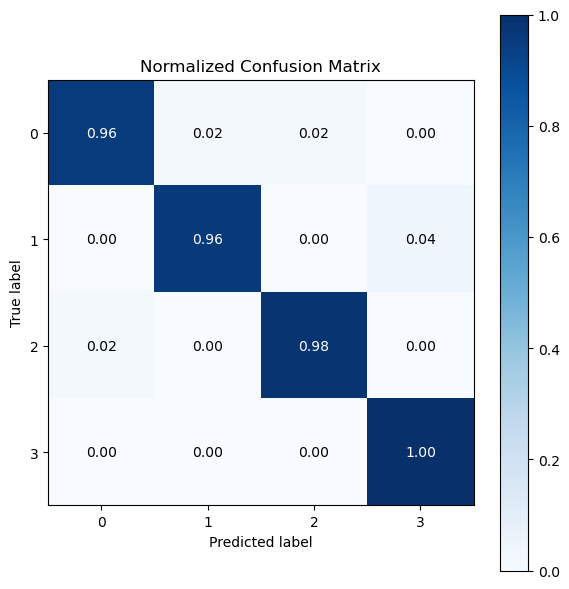

==== Min variance model
Classification:    accuracy  balanced_accuracy
0  0.842857           0.861453
Probabilistic:    log_loss  brier_score
0  0.673384     0.367406
ECE: 0.1640104803115232
              precision    recall  f1-score   support

           0       0.75      0.85      0.80        46
           1       0.97      0.79      0.87        75
           2       0.84      0.81      0.83        53
           3       0.78      1.00      0.88        36

    accuracy                           0.84       210
   macro avg       0.84      0.86      0.84       210
weighted avg       0.86      0.84      0.84       210



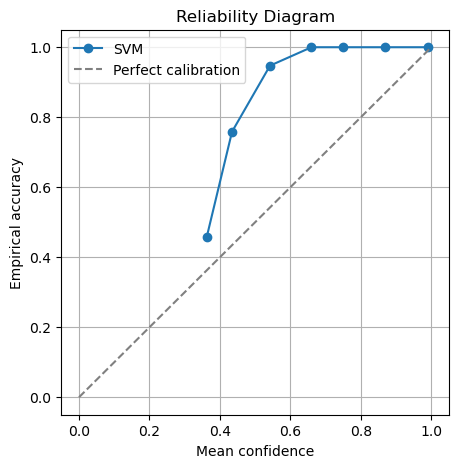

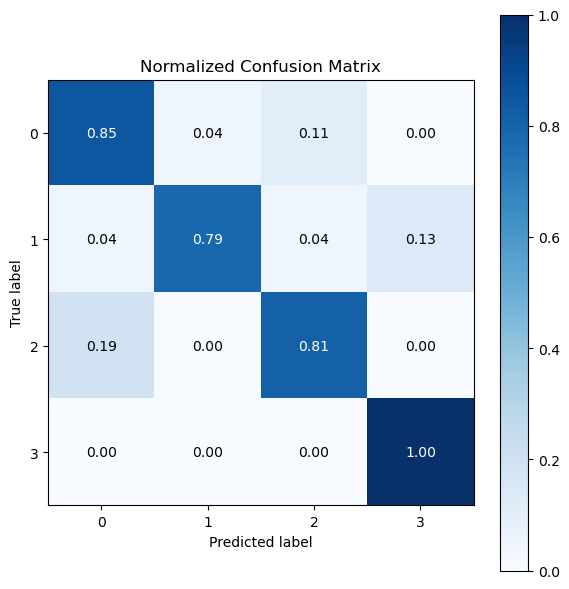

In [53]:
metric_bm = kNN_Metric(
  model=model_bm,
  X_test=X_test,
  y_test=y_enc_test
)

metric_bs = kNN_Metric(
  model=model_bs,
  X_test=X_test,
  y_test=y_enc_test
)

results_bm = metric_bm.evaluate()
results_bs = metric_bs.evaluate()

print("==== Max mean model")
print("Classification:", pd.DataFrame([results_bm["classification"]]) )
print("Probabilistic:", pd.DataFrame([results_bm["probabilistic"]]) )
print("ECE:", results_bm["ece"])
print(results_bm["classwise"]["classification_report"])
metric_bm.plot_reliability_diagram(n_bins=10)
metric_bm.plot_confusion_matrix(normalize=True, cmap="Blues")

print("==== Min variance model")
print("Classification:", pd.DataFrame([results_bs["classification"]]) )
print("Probabilistic:", pd.DataFrame([results_bs["probabilistic"]]) )
print("ECE:", results_bs["ece"])
print(results_bs["classwise"]["classification_report"])
metric_bs.plot_reliability_diagram(n_bins=10)
metric_bs.plot_confusion_matrix(normalize=True, cmap="Blues")